# goquant + pyalgotrade backtesting example: market_timing algo

# Example1. pyalgotrade example day freq

# 1. stepup goquant path

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# 2. prepare backtesting csv data files

In [31]:
from controller.data.data import Data

symbols = ["SPY", "VTI", "VEU", "IEF", "VNQ", "DBC"]
data = Data()
data_df = data.get_prices(symbols=symbols, freq="day", length=300*1) # past 1 year
for symbol in symbols:
    cur_df = data_df[symbol].rename(
        {'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'},
        axis=1)
    cur_df['Adj Close'] = cur_df['Close']
    cur_df.index.names = ['Date Time']
    cur_df.index = cur_df.index.astype(str).str[:-6]
    cur_df.dropna(inplace=True)
    cur_df.to_csv(symbol+".csv")

In [32]:
import pandas as pd
data = pd.read_csv("DBC.csv") 
data

,Date Time,Open,High,Low,Close,Volume,Adj Close
0,2018-05-30 00:00:00,17.93,18.0800,17.9000,18.080,2263114.0,18.080
1,2018-05-31 00:00:00,18.09,18.1800,17.9400,18.020,2467913.0,18.020
2,2018-06-01 00:00:00,17.94,17.9700,17.8600,17.910,4897638.0,17.910
3,2018-06-04 00:00:00,17.89,17.8900,17.7000,17.720,2696562.0,17.720
4,2018-06-05 00:00:00,17.67,17.7590,17.6200,17.720,2940454.0,17.720
5,2018-06-06 00:00:00,17.72,17.8200,17.6600,17.790,2307753.0,17.790
6,2018-06-07 00:00:00,17.79,17.8900,17.7800,17.870,1562656.0,17.870
7,2018-06-08 00:00:00,17.86,17.9000,17.7800,17.850,1937169.0,17.850
8,2018-06-11 00:00:00,17.74,17.8750,17.7400,17.840,2106619.0,17.840
9,2018-06-12 00:00:00,17.77,17.9000,17.7700,17.840,1060199.0,17.840


# 3. run backtesting for algo

INFO:strategy:Rebalancing
2018-05-29 00:00:00 strategy [INFO] Rebalancing
INFO:strategy:Best for class US Stocks: None
2018-05-29 00:00:00 strategy [INFO] Best for class US Stocks: None
INFO:strategy:Best for class Foreign Stocks: None
2018-05-29 00:00:00 strategy [INFO] Best for class Foreign Stocks: None
INFO:strategy:Best for class US 10 Year Government Bonds: None
2018-05-29 00:00:00 strategy [INFO] Best for class US 10 Year Government Bonds: None
INFO:strategy:Best for class Real Estate: None
2018-05-29 00:00:00 strategy [INFO] Best for class Real Estate: None
INFO:strategy:Best for class Commodities: None
2018-05-29 00:00:00 strategy [INFO] Best for class Commodities: None
INFO:strategy:Rebalancing
2018-06-01 00:00:00 strategy [INFO] Rebalancing
INFO:strategy:Best for class US Stocks: None
2018-06-01 00:00:00 strategy [INFO] Best for class US Stocks: None
INFO:strategy:Best for class Foreign Stocks: None
2018-06-01 00:00:00 strategy [INFO] Best for class Foreign Stocks: None
INFO

INFO:strategy:Rebalancing
2019-05-01 00:00:00 strategy [INFO] Rebalancing
INFO:strategy:Best for class US Stocks: VTI
2019-05-01 00:00:00 strategy [INFO] Best for class US Stocks: VTI
INFO:strategy:Best for class Foreign Stocks: VEU
2019-05-01 00:00:00 strategy [INFO] Best for class Foreign Stocks: VEU
INFO:strategy:Best for class US 10 Year Government Bonds: IEF
2019-05-01 00:00:00 strategy [INFO] Best for class US 10 Year Government Bonds: IEF
INFO:strategy:Best for class Real Estate: VNQ
2019-05-01 00:00:00 strategy [INFO] Best for class Real Estate: VNQ
INFO:strategy:Best for class Commodities: None
2019-05-01 00:00:00 strategy [INFO] Best for class Commodities: None
INFO:strategy:Placing market order for 13 VTI shares
2019-05-01 00:00:00 strategy [INFO] Placing market order for 13 VTI shares
INFO:strategy:Placing market order for 39 VEU shares
2019-05-01 00:00:00 strategy [INFO] Placing market order for 39 VEU shares
INFO:strategy:Placing market order for 18 IEF shares
2019-05-01 

Sharpe ratio: -1.97
Returns: -1.01 %


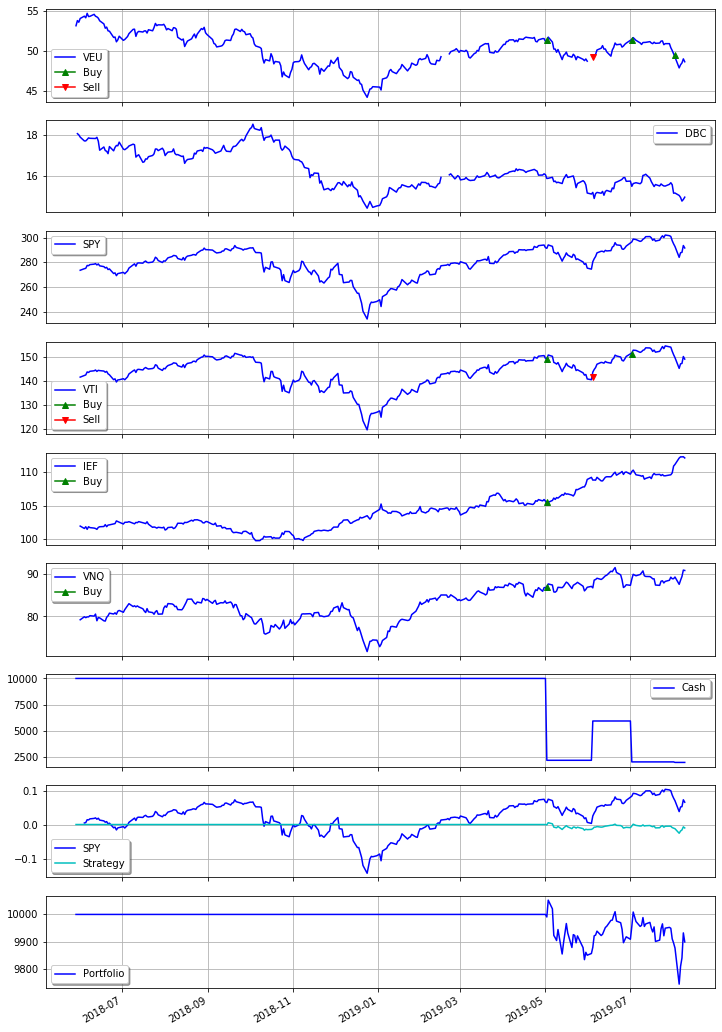

In [37]:
# get file from https://github.com/gbeced/pyalgotrade/blob/master/samples/market_timing.py

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 20) # (w, h)

from pyalgotrade import strategy
from pyalgotrade import plotter
from pyalgotrade.barfeed import yahoofeed, csvfeed
from pyalgotrade.technical import ma
from pyalgotrade.technical import cumret
from pyalgotrade.stratanalyzer import sharpe
from pyalgotrade.stratanalyzer import returns


class MarketTiming(strategy.BacktestingStrategy):
    def __init__(self, feed, instrumentsByClass, initialCash):
        super(MarketTiming, self).__init__(feed, initialCash)
        self.setUseAdjustedValues(True)
        self.__instrumentsByClass = instrumentsByClass
        self.__rebalanceMonth = None
        self.__sharesToBuy = {}
        # Initialize indicators for each instrument.
        self.__sma = {}
        for assetClass in instrumentsByClass:
            for instrument in instrumentsByClass[assetClass]:
                priceDS = feed[instrument].getPriceDataSeries()
                self.__sma[instrument] = ma.SMA(priceDS, 200)

    def _shouldRebalance(self, dateTime):
        return dateTime.month != self.__rebalanceMonth

    def _getRank(self, instrument):
        # If the price is below the SMA, then this instrument doesn't rank at
        # all.
        smas = self.__sma[instrument]
        price = self.getLastPrice(instrument)
        if len(smas) == 0 or smas[-1] is None or price < smas[-1]:
            return None

        # Rank based on 20 day returns.
        ret = None
        lookBack = 20
        priceDS = self.getFeed()[instrument].getPriceDataSeries()
        if len(priceDS) >= lookBack and smas[-1] is not None and smas[-1*lookBack] is not None:
            ret = (priceDS[-1] - priceDS[-1*lookBack]) / float(priceDS[-1*lookBack])
        return ret

    def _getTopByClass(self, assetClass):
        # Find the instrument with the highest rank.
        ret = None
        highestRank = None
        for instrument in self.__instrumentsByClass[assetClass]:
            rank = self._getRank(instrument)
            if rank is not None and (highestRank is None or rank > highestRank):
                highestRank = rank
                ret = instrument
        return ret

    def _getTop(self):
        ret = {}
        for assetClass in self.__instrumentsByClass:
            ret[assetClass] = self._getTopByClass(assetClass)
        return ret

    def _placePendingOrders(self):
        # Use less chash just in case price changes too much.
        remainingCash = round(self.getBroker().getCash() * 0.9, 2)

        for instrument in self.__sharesToBuy:
            orderSize = self.__sharesToBuy[instrument]
            if orderSize > 0:
                # Adjust the order size based on available cash.
                lastPrice = self.getLastPrice(instrument)
                cost = orderSize * lastPrice
                while cost > remainingCash and orderSize > 0:
                    orderSize -= 1
                    cost = orderSize * lastPrice
                if orderSize > 0:
                    remainingCash -= cost
                    assert(remainingCash >= 0)

            if orderSize != 0:
                self.info("Placing market order for %d %s shares" % (orderSize, instrument))
                self.marketOrder(instrument, orderSize, goodTillCanceled=True)
                self.__sharesToBuy[instrument] -= orderSize

    def _logPosSize(self):
        totalEquity = self.getBroker().getEquity()
        positions = self.getBroker().getPositions()
        for instrument in self.getBroker().getPositions():
            posSize = positions[instrument] * self.getLastPrice(instrument) / totalEquity * 100
            self.info("%s - %0.2f %%" % (instrument, posSize))

    def _rebalance(self):
        self.info("Rebalancing")

        # Cancel all active/pending orders.
        for order in self.getBroker().getActiveOrders():
            self.getBroker().cancelOrder(order)

        cashPerAssetClass = round(self.getBroker().getEquity() / float(len(self.__instrumentsByClass)), 2)
        self.__sharesToBuy = {}

        # Calculate which positions should be open during the next period.
        topByClass = self._getTop()
        for assetClass in topByClass:
            instrument = topByClass[assetClass]
            self.info("Best for class %s: %s" % (assetClass, instrument))
            if instrument is not None:
                lastPrice = self.getLastPrice(instrument)
                cashForInstrument = round(cashPerAssetClass - self.getBroker().getShares(instrument) * lastPrice, 2)
                # This may yield a negative value and we have to reduce this
                # position.
                self.__sharesToBuy[instrument] = int(cashForInstrument / lastPrice)

        # Calculate which positions should be closed.
        for instrument in self.getBroker().getPositions():
            if instrument not in topByClass.values():
                currentShares = self.getBroker().getShares(instrument)
                assert(instrument not in self.__sharesToBuy)
                self.__sharesToBuy[instrument] = currentShares * -1

    def getSMA(self, instrument):
        return self.__sma[instrument]

    def onBars(self, bars):
        currentDateTime = bars.getDateTime()

        if self._shouldRebalance(currentDateTime):
            self.__rebalanceMonth = currentDateTime.month
            self._rebalance()

        self._placePendingOrders()


def main(plot):
    initialCash = 10000
    instrumentsByClass = {
        "US Stocks": ["VTI"],
        "Foreign Stocks": ["VEU"],
        "US 10 Year Government Bonds": ["IEF"],
        "Real Estate": ["VNQ"],
        "Commodities": ["DBC"],
    }

    # Load the bars. These files were manually downloaded from Yahoo Finance.
    #feed = yahoofeed.Feed()
    feed = csvfeed.GenericBarFeed(frequency="minute")
    instruments = ["SPY"]
    for assetClass in instrumentsByClass:
        instruments.extend(instrumentsByClass[assetClass])

    for instrument in instruments:
        fileName = "%s.csv" % instrument
        feed.addBarsFromCSV(instrument, fileName)

    # Build the strategy and attach some metrics.
    strat = MarketTiming(feed, instrumentsByClass, initialCash)
    sharpeRatioAnalyzer = sharpe.SharpeRatio()
    strat.attachAnalyzer(sharpeRatioAnalyzer)
    returnsAnalyzer = returns.Returns()
    strat.attachAnalyzer(returnsAnalyzer)

    if plot:
        plt = plotter.StrategyPlotter(strat)
        plt.getOrCreateSubplot("cash").addCallback("Cash", lambda x: strat.getBroker().getCash())
        # Plot strategy vs. SPY cumulative returns.
        plt.getOrCreateSubplot("returns").addDataSeries("SPY", cumret.CumulativeReturn(feed["SPY"].getPriceDataSeries()))
        plt.getOrCreateSubplot("returns").addDataSeries("Strategy", returnsAnalyzer.getCumulativeReturns())

    strat.run()
    print("Sharpe ratio: %.2f" % sharpeRatioAnalyzer.getSharpeRatio(0.05))
    print("Returns: %.2f %%" % (returnsAnalyzer.getCumulativeReturns()[-1] * 100))

    if plot:
        plt.plot()

main(True)

# Example 2: alpaca algo day freq (unfinished)

In [ ]:
Universe = ['MMM', 'ABT', 'ABBV', 'ACN', 'ATVI', 'AYI', 'ADBE', 'AMD', 'AAP', 'AES', 'AET', 'AMG', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN', 'ALGN', 'ALLE', 'AGN', 'ADS', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'APC', 'ADI', 'ANDV', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'AIV', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ARNC', 'AJG', 'AIZ', 'T', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BHGE', 'BLL', 'BAC', 'BK', 'BAX', 'BBT', 'BDX', 'BRK.B', 'BBY', 'BIIB', 'BLK', 'HRB', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BHF', 'BMY', 'AVGO', 'BF.B', 'CHRW', 'CA', 'COG', 'CDNS', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CAT', 'CBOE', 'CBRE', 'CBS', 'CELG', 'CNC', 'CNP', 'CTL', 'CERN', 'CF', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'XEC', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'CXO', 'COP', 'ED', 'STZ', 'COO', 'GLW', 'COST', 'COTY', 'CCI', 'CSX', 'CMI', 'CVS', 'DHI', 'DHR', 'DRI', 'DVA', 'DE', 'DAL', 'XRAY', 'DVN', 'DLR', 'DFS', 'DISCA', 'DISCK', 'DISH', 'DG', 'DLTR', 'D', 'DOV', 'DWDP', 'DPS', 'DTE', 'DRE', 'DUK', 'DXC', 'ETFC', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'EMR', 'ETR', 'EVHC', 'EOG', 'EQT', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL', 'ES', 'RE', 'EXC', 'EXPE', 'EXPD', 'ESRX', 'EXR', 'XOM', 'FFIV', 'FB', 'FAST', 'FRT', 'FDX', 'FIS', 'FITB', 'FE', 'FISV', 'FLIR', 'FLS', 'FLR', 'FMC', 'FL', 'F', 'FTV', 'FBHS', 'BEN', 'FCX', 'GPS', 'GRMN', 'IT', 'GD', 'GE', 'GGP', 'GIS', 'GM', 'GPC', 'GILD', 'GPN', 'GS', 'GT', 'GWW', 'HAL', 'HBI', 'HOG', 'HRS', 'HIG', 'HAS', 'HCA', 'HCP', 'HP', 'HSIC', 'HSY', 'HES', 'HPE', 'HLT', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HPQ', 'HUM', 'HBAN', 'HII', 'IDXX', 'INFO', 'ITW', 'ILMN', 'IR', 'INTC', 'ICE', 'IBM', 'INCY', 'IP', 'IPG', 'IFF', 'INTU', 'ISRG', 'IVZ', 'IPGP', 'IQV', 'IRM', 'JEC', 'JBHT', 'SJM', 'JNJ', 'JCI', 'JPM', 'JNPR', 'KSU', 'K', 'KEY', 'KMB', 'KIM', 'KMI', 'KLAC', 'KSS', 'KHC', 'KR', 'LB', 'LLL', 'LH', 'LRCX', 'LEG', 'LEN', 'LUK', 'LLY', 'LNC', 'LKQ', 'LMT', 'L', 'LOW', 'LYB', 'MTB', 'MAC', 'M', 'MRO', 'MPC', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MAT', 'MKC', 'MCD', 'MCK', 'MDT', 'MRK', 'MET', 'MTD', 'MGM', 'KORS', 'MCHP', 'MU', 'MSFT', 'MAA', 'MHK', 'TAP', 'MDLZ', 'MON', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MSCI', 'MYL', 'NDAQ', 'NOV', 'NAVI', 'NKTR', 'NTAP', 'NFLX', 'NWL', 'NFX', 'NEM', 'NWSA', 'NWS', 'NEE', 'NLSN', 'NKE', 'NI', 'NBL', 'JWN', 'NSC', 'NTRS', 'NOC', 'NCLH', 'NRG', 'NUE', 'NVDA', 'ORLY', 'OXY', 'OMC', 'OKE', 'ORCL', 'PCAR', 'PKG', 'PH', 'PAYX', 'PYPL', 'PNR', 'PBCT', 'PEP', 'PKI', 'PRGO', 'PFE', 'PCG', 'PM', 'PSX', 'PNW', 'PXD', 'PNC', 'RL', 'PPG', 'PPL', 'PX', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PSA', 'PHM', 'PVH', 'QRVO', 'PWR', 'QCOM', 'DGX', 'RRC', 'RJF', 'RTN', 'O', 'RHT', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RHI', 'ROK', 'COL', 'ROP', 'ROST', 'RCL', 'CRM', 'SBAC', 'SCG', 'SLB', 'STX', 'SEE', 'SRE', 'SHW', 'SPG', 'SWKS', 'SLG', 'SNA', 'SO', 'LUV', 'SPGI', 'SWK', 'SBUX', 'STT', 'SRCL', 'SYK', 'STI', 'SIVB', 'SYMC', 'SYF', 'SNPS', 'SYY', 'TROW', 'TTWO', 'TPR', 'TGT', 'TEL', 'FTI', 'TXN', 'TXT', 'TMO', 'TIF', 'TWX', 'TJX', 'TMK', 'TSS', 'TSCO', 'TDG', 'TRV', 'TRIP', 'FOXA', 'FOX', 'TSN', 'UDR', 'ULTA', 'USB', 'UAA', 'UA', 'UNP', 'UAL', 'UNH', 'UPS', 'URI', 'UTX', 'UHS', 'UNM', 'VFC', 'VLO', 'VAR', 'VTR', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VIAB', 'V', 'VNO', 'VMC', 'WMT', 'WBA', 'DIS', 'WM', 'WAT', 'WEC', 'WFC', 'WELL', 'WDC', 'WU', 'WRK', 'WY', 'WHR', 'WMB', 'WLTW', 'WYN', 'WYNN', 'XEL', 'XRX', 'XLNX', 'XL', 'XYL', 'YUM', 'ZBH', 'ZION', 'ZTS']  # noqa

class AlpacaAlgo(strategy.BacktestingStrategy):
    def __init__(self, feed, instrumentsByClass, initialCash):
        super(MarketTiming, self).__init__(feed, initialCash)
        self.setUseAdjustedValues(True)
        self.__instrumentsByClass = instrumentsByClass
        self.__rebalanceMonth = None
        self.__sharesToBuy = {}
        # Initialize indicators for each instrument.
        self.__sma = {}
        for assetClass in instrumentsByClass:
            for instrument in instrumentsByClass[assetClass]:
                priceDS = feed[instrument].getPriceDataSeries()
                self.__sma[instrument] = ma.SMA(priceDS, 200)
        self.position_size = 100
        self.max_positions = 5

    def _shouldRebalance(self, dateTime):
        return dateTime.month != self.__rebalanceMonth

    def _getRank(self, instrument):
        # If the price is below the SMA, then this instrument doesn't rank at
        # all.
        smas = self.__sma[instrument]
        price = self.getLastPrice(instrument)
        if len(smas) == 0 or smas[-1] is None or price < smas[-1]:
            return None

        # Rank based on 20 day returns.
        ret = None
        lookBack = 20
        priceDS = self.getFeed()[instrument].getPriceDataSeries()
        if len(priceDS) >= lookBack and smas[-1] is not None and smas[-1*lookBack] is not None:
            ret = (priceDS[-1] - priceDS[-1*lookBack]) / float(priceDS[-1*lookBack])
        return ret

    def _getTopByClass(self, assetClass):
        # Find the instrument with the highest rank.
        ret = None
        highestRank = None
        for instrument in self.__instrumentsByClass[assetClass]:
            rank = self._getRank(instrument)
            if rank is not None and (highestRank is None or rank > highestRank):
                highestRank = rank
                ret = instrument
        return ret

    def _getTop(self):
        ret = {}
        for assetClass in self.__instrumentsByClass:
            ret[assetClass] = self._getTopByClass(assetClass)
        return ret

    def _placePendingOrders(self):
        # Use less chash just in case price changes too much.
        remainingCash = round(self.getBroker().getCash() * 0.9, 2)

        for instrument in self.__sharesToBuy:
            orderSize = self.__sharesToBuy[instrument]
            if orderSize > 0:
                # Adjust the order size based on available cash.
                lastPrice = self.getLastPrice(instrument)
                cost = orderSize * lastPrice
                while cost > remainingCash and orderSize > 0:
                    orderSize -= 1
                    cost = orderSize * lastPrice
                if orderSize > 0:
                    remainingCash -= cost
                    assert(remainingCash >= 0)

            if orderSize != 0:
                self.info("Placing market order for %d %s shares" % (orderSize, instrument))
                self.marketOrder(instrument, orderSize, goodTillCanceled=True)
                self.__sharesToBuy[instrument] -= orderSize

    def _logPosSize(self):
        totalEquity = self.getBroker().getEquity()
        positions = self.getBroker().getPositions()
        for instrument in self.getBroker().getPositions():
            posSize = positions[instrument] * self.getLastPrice(instrument) / totalEquity * 100
            self.info("%s - %0.2f %%" % (instrument, posSize))

    def _rebalance(self):
        self.info("Rebalancing")

        # Cancel all active/pending orders.
        for order in self.getBroker().getActiveOrders():
            self.getBroker().cancelOrder(order)

        cashPerAssetClass = round(self.getBroker().getEquity() / float(len(self.__instrumentsByClass)), 2)
        self.__sharesToBuy = {}

        # Calculate which positions should be open during the next period.
        topByClass = self._getTop()
        for assetClass in topByClass:
            instrument = topByClass[assetClass]
            self.info("Best for class %s: %s" % (assetClass, instrument))
            if instrument is not None:
                lastPrice = self.getLastPrice(instrument)
                cashForInstrument = round(cashPerAssetClass - self.getBroker().getShares(instrument) * lastPrice, 2)
                # This may yield a negative value and we have to reduce this
                # position.
                self.__sharesToBuy[instrument] = int(cashForInstrument / lastPrice)

        # Calculate which positions should be closed.
        for instrument in self.getBroker().getPositions():
            if instrument not in topByClass.values():
                currentShares = self.getBroker().getShares(instrument)
                assert(instrument not in self.__sharesToBuy)
                self.__sharesToBuy[instrument] = currentShares * -1

    def getSMA(self, instrument):
        return self.__sma[instrument]
    
    def _calc_scores(self, price_df, dayindex=-1):
        '''Calculate scores based on the indicator and
        return the sorted result.
        '''
        diffs = {}
        param = 10
        for symbol in price_df.columns.levels[0]:
            df = price_df[symbol]
            if len(df.close.values) <= param:
                continue
            ema = df.close.ewm(span=param).mean()[dayindex]
            last = df.close.values[dayindex]
            diff = (last - ema) / last
            diffs[symbol] = diff
        return sorted(diffs.items(), key=lambda x: x[1])
    
    def _get_order(self, cur_time):
        '''Calculate the scores within the universe to build the optimal
        portfolio as of today, and extract orders to transition from our
        current portfolio to the desired state.
        '''

        # get data
        NY = 'America/New_York'
        now = cur_time
        end_dt = now
        if now.time() >= pd.Timestamp('09:30', tz=NY).time():
            end_dt = now - \
                     pd.Timedelta(now.strftime('%H:%M:%S')) - pd.Timedelta('1 minute')

        start_dt = end_dt - pd.Timedelta('50 days')
        price_df = self.data.get_prices(Universe, start_dt, end_dt, "day")

        # rank the stocks based on the indicators.
        ranked = self._calc_scores(price_df)
        to_buy = set()
        to_sell = set()
        # take the top one twentieth out of ranking,
        # excluding stocks too expensive to buy a share
        for symbol, _ in ranked[:len(ranked) // 20]:
            price = float(price_df[symbol].close.values[-1])
            if price > float(self.account.get_cash()):
                continue
            to_buy.add(symbol)

        # now get the current positions and see what to buy,
        # what to sell to transition to today's desired portfolio.
        positions = self.account.get_positions()
        logger.info(positions)
        holdings = {p.symbol: p for p in positions}
        holding_symbol = set(holdings.keys())
        to_sell = holding_symbol - to_buy
        to_buy = to_buy - holding_symbol
        orders = []

        # if a stock is in the portfolio, and not in the desired
        # portfolio, sell it
        for symbol in to_sell:
            shares = holdings[symbol].qty
            orders.append(Order(symbol=symbol, qty=shares, side='sell'))
            logger.info(f'order(sell): {symbol} for {shares}')

        # likewise, if the portfoio is missing stocks from the
        # desired portfolio, buy them. We sent a limit for the total
        # position size so that we don't end up holding too many positions.
        max_to_buy = self.max_positions - (len(positions) - len(to_sell))
        for symbol in to_buy:
            if max_to_buy <= 0:
                break
            shares = self.position_size // float(price_df[symbol].close.values[-1])
            if shares == 0.0:
                continue
            orders.append(Order(symbol=symbol, qty=shares, side='buy'))
            logger.info(f'order(buy): {symbol} for {shares}')
            max_to_buy -= 1
        return orders

    def onBars(self, bars):
        currentDateTime = bars.getDateTime()
        
        self.marketOrder(instrument, orderSize, goodTillCanceled=True)

        if self._shouldRebalance(currentDateTime):
            self.__rebalanceMonth = currentDateTime.month
            self._rebalance()

        self._placePendingOrders()
        
class AlgoBuySPYDip(BaseAlgo):
    def init(self):
        self.position_size = 100
        self.max_positions = 5

    def get_order(self):
        '''Calculate the scores within the universe to build the optimal
        portfolio as of today, and extract orders to transition from our
        current portfolio to the desired state.
        '''

        # get data
        NY = 'America/New_York'
        now = pd.Timestamp.now(tz=NY)
        end_dt = now
        if now.time() >= pd.Timestamp('09:30', tz=NY).time():
            end_dt = now - \
                     pd.Timedelta(now.strftime('%H:%M:%S')) - pd.Timedelta('1 minute')

        start_dt = end_dt - pd.Timedelta('50 days')
        price_df = self.data.get_prices(Universe, start_dt, end_dt, "day")

        # rank the stocks based on the indicators.
        ranked = self._calc_scores(price_df)
        to_buy = set()
        to_sell = set()
        # take the top one twentieth out of ranking,
        # excluding stocks too expensive to buy a share
        for symbol, _ in ranked[:len(ranked) // 20]:
            price = float(price_df[symbol].close.values[-1])
            if price > float(self.account.get_cash()):
                continue
            to_buy.add(symbol)

        # now get the current positions and see what to buy,
        # what to sell to transition to today's desired portfolio.
        positions = self.account.get_positions()
        logger.info(positions)
        holdings = {p.symbol: p for p in positions}
        holding_symbol = set(holdings.keys())
        to_sell = holding_symbol - to_buy
        to_buy = to_buy - holding_symbol
        orders = []

        # if a stock is in the portfolio, and not in the desired
        # portfolio, sell it
        for symbol in to_sell:
            shares = holdings[symbol].qty
            orders.append(Order(symbol=symbol, qty=shares, side='sell'))
            logger.info(f'order(sell): {symbol} for {shares}')

        # likewise, if the portfoio is missing stocks from the
        # desired portfolio, buy them. We sent a limit for the total
        # position size so that we don't end up holding too many positions.
        max_to_buy = self.max_positions - (len(positions) - len(to_sell))
        for symbol in to_buy:
            if max_to_buy <= 0:
                break
            shares = self.position_size // float(price_df[symbol].close.values[-1])
            if shares == 0.0:
                continue
            orders.append(Order(symbol=symbol, qty=shares, side='buy'))
            logger.info(f'order(buy): {symbol} for {shares}')
            max_to_buy -= 1
        return orders

    def _calc_scores(self, price_df, dayindex=-1):
        '''Calculate scores based on the indicator and
        return the sorted result.
        '''
        diffs = {}
        param = 10
        for symbol in price_df.columns.levels[0]:
            df = price_df[symbol]
            if len(df.close.values) <= param:
                continue
            ema = df.close.ewm(span=param).mean()[dayindex]
            last = df.close.values[dayindex]
            diff = (last - ema) / last
            diffs[symbol] = diff
        return sorted(diffs.items(), key=lambda x: x[1])
    
